In [81]:
import os
import pathlib
import time
import datetime
import math
import numpy as np
import cv2
import random

from matplotlib import pyplot as plt
from IPython import display

In [82]:
def showImage(image, size, axis = "off"):
    plt.figure(figsize=(size, size))
    plt.imshow(image)
    plt.axis(axis)

In [83]:
base_colors = [[255, 160, 151], [249, 178, 135], [255, 232, 163], [145, 209, 255], [0, 0, 0], [144, 126, 208]]
pattern_colors = [
    [
        [231, 242, 167],
        [90, 125, 166],
        [119, 176, 242],
        [249, 178, 135]
    ],
    [
        [129, 119, 242],
        [249, 209, 135],
        [249, 145, 135],
        [119, 174, 242]
    ],
    [
        [119, 141, 242],
        [242, 131, 153],
        [242, 181, 143],
        [115, 107, 102]
    ],
    [
        [242, 162, 238],
        [242, 242, 114],
        [166, 166, 86],
        [213, 231, 244]
    ],
    [
        [142, 70, 242],
        [242, 236, 34],
        [46, 170, 242],
        [242, 70, 77]
    ],
    [
        [242, 88, 70],
        [46, 170, 242],
        [242, 220, 22],
        [242, 158, 46]
    ]
]
pattern_type = [
    ["#01", "#07", "#08", "#13", "02.", "07-", "10-", "15."],
    ["#05", "#11", "08"],
    ["01-", "04.", "05-", "13.", "16.", "17.", "18."],
    ["#12", "ana", "gal", "#20"],
    ["03.", "09-", "14,"],
    ["#02", "#04", "com", "dig", "11-", "12."]
]
flower_names = [
    [
        [
            ["lavender_5_zigzag_1", "lavender_9_zigzag_1", "lavender_9_zigzag_1"],
            ["lavender_9_split_1", "lavender_5_split_1", "lavender_5_split_1"],
            ["tulip_3_2", "tulip_5_2", "tulip_9_1"],
            ["tulip_3_2", "tulip_5_2", "tulip_9_1"]
        ],
        [
            ["Dandelion_04_ripple_2", "Dandelion_04_ripple_2", "Dandelion_04_ripple_2"],
            ["Rose_bush_round_1", "Rose_bush_round_1", "Rose_bush_round_1"],
            ["dandelion_02_petal_1_2", "dandelion_02_petal_1_2", "dandelion_02_petal_1_2"],
            ["Dandelion_04_ripple_2", "Dandelion_04_ripple_2", "Dandelion_04_ripple_2"]
        ]
    ],
    [
        [
            ["Rose_5_zigzag_0", "Rose_5_zigzag_0", "Rose_5_zigzag_0"],
            ["Dandelion_04_1", "Dandelion_04_1", "Dandelion_04_1"],
            ["Rose_5_zigzag_0", "Rose_5_zigzag_0", "Rose_5_zigzag_0"],
            ["Dandelion_04_1", "Dandelion_04_1", "Dandelion_04_1"]
        ],
        [
            ["Rose_01_05_petal_4_1", "Daises_4_0", "daisy_single_4_1"],
            ["rose_01_06_petal_8_1", "Daises_8_0", "daisy_single_8_1"],
            ["Daises_5_0", "daisy_single_5_1", "daisy_single_5_1"],
            ["Daises_5_0", "daisy_single_5_1", "daisy_single_5_1"]
        ]
    ],
]

In [84]:
def generateRefInput():
    sample_image = numpy.ones((1024, 1024, 3)) * 255
    plt.figure()
    # plt.imshow(sample_image)
    for i in range(1024):
        for j in range(1024):
            if (((i - 320)**2 + (j - 400)**2) < (80**2) or ((i - 400)**2 + (j - 740)**2) < (210**2) or ((i - 650)**2 + (j - 470)**2) < (120**2)):
            # if (((i - 720)**2 + (j - 230)**2) < (180**2) or ((i - 650)**2 + (j - 740)**2) < (140**2)):
                sample_image[i, j, :] = [255, 0, 0]

    sample_image = tf.cast(sample_image, tf.uint8).numpy()

    # plt.figure()
    # plt.imshow(sample_image)
    plt.imsave('../Scripts/output1.png', sample_image)

In [85]:
def addColor(pattern, color):
    red = color[0]
    green = color[1]
    blue = color[2]
    pattern[:, :, 0] = pattern[:, :, 0] * color[0]
    pattern[:, :, 1] = pattern[:, :, 1] * color[1]
    pattern[:, :, 2] = pattern[:, :, 2] * color[2]
    
    return pattern

In [86]:
def addColorMatrix(pattern, color, reverse = False):
    newPattern = pattern.copy()
    color_copy = color.copy()
    if reverse:
        newPattern = 255 - newPattern
        color_copy = 1 - color_copy
        color_copy[3] = 0
        
    newPattern[:, :, 0] = newPattern[:, :, 0] * color_copy[:, :, 0]
    newPattern[:, :, 1] = newPattern[:, :, 1] * color_copy[:, :, 1]
    newPattern[:, :, 2] = newPattern[:, :, 2] * color_copy[:, :, 2]
    
    if reverse:
        newPattern = 255 - newPattern
    
    return newPattern

In [87]:
def changeIntoPattern(pattern, background, position, radius, color):
    pattern_copy = pattern.copy()
    
    # print(pattern_copy)
    
    # pattern_ = pattern.copy()
    # pattern_ = cv2.resize(pattern_, dsize = (20, 20), interpolation=cv2.INTER_AREA)
    # pattern_ = addColor(pattern_, [1, 0, 0])
    # print(pattern_[3:7, 3:7])
    # showImage(pattern_, 3)
    
    pattern_copy = cv2.resize(pattern_copy, dsize=(1024, 1024), interpolation=cv2.INTER_AREA)
    # print(pattern_copy[350:360, 350:360])
    pattern_colored = addColorMatrix(pattern_copy, color)
    # showImage(pattern_colored, 3)
    # print(pattern_colored[350:360, 350:360])
    pattern_resized = cv2.resize(pattern_colored, dsize = (int(radius*2 * 500/400), int(radius*2 * 500/400)), interpolation=cv2.INTER_AREA)
    _, mask = cv2.threshold(pattern_resized[:,:,3], 1, 255, cv2.THRESH_BINARY)
    
    # pattern_resized = cv2.cvtColor(pattern_resized, cv2.COLOR_BGRA2BGR)
    w, h = pattern_resized.shape[:2]
    leftSide = position[1]-w//2
    rightSide = position[1]+w//2+w%2
    upperSide = position[0]-h//2
    lowerSide = position[0]+h//2+h%2
    # (pattern_resized.shape, mask.shape)
    if leftSide < 0:
        pattern_resized = pattern_resized[-leftSide:, :]
        mask = mask[-leftSide:, :]
        leftSide = 0
    if rightSide >= background.shape[1]:
        pattern_resized = pattern_resized[:w - rightSide + background.shape[1] - 1, :]
        mask = mask[:w - rightSide + background.shape[1] - 1, :]
        rightSide = background.shape[1] - 1
    if upperSide < 0:
        pattern_resized = pattern_resized[:, -upperSide:]
        mask = mask[:, -upperSide:]
        upperSide = 0
    if lowerSide >= background.shape[0]:
        pattern_resized = pattern_resized[:, :h - lowerSide + background.shape[0]]
        mask = mask[:, :h - lowerSide + background.shape[0]]
        lowerSide = background.shape[0]
        
    mask_inv = cv2.bitwise_not(mask)
    
    roi = background[leftSide:rightSide, upperSide:lowerSide]
    # masked_fg = cv2.bitwise_and(pattern_resized, pattern_resized, mask=mask)
    # masked_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    # masked_bg = cv2.cvtColor(masked_bg, cv2.COLOR_RGB2RGBA)
    # masked_bg[:, :, 3] = masked_bg[:, :, 3] * 0
    
    added = pattern_resized + roi
    
    background[leftSide:rightSide, upperSide:lowerSide] = added
    
    # background_copy = cv2.resize(background, dsize = (15, 15), interpolation=cv2.INTER_AREA)
    
    # background = cv2.resize(background, dsize=(15, 15), interpolation=cv2.INTER_AREA)
    
    # print(background_copy)
    
    # showImage(background[:, :, :3], 3)
    
    return background

In [88]:
def getColorMap(size, color, type="single"):
    if type == "single":
        colorMap = np.ones((size, size, 4))
        colorMap = colorMap.astype(np.float32)
        w, h = colorMap.shape[:2]

        for i in range(w):
            for j in range(h):
                colorMap[i, j] = color
        
    return colorMap

In [89]:
def generateLayer(input, pattern, colorMap):
    if input == 1:
        circles = patternCircles1
    elif input == 2:
        circles = patternCircles2
    # image = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, dsize = (1024, 1024), interpolation=cv2.INTER_AREA)
    # # dst = image.copy()
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 150, param1 = 300, param2 = 14, minRadius = 10, maxRadius = 800)
        
    # if circles is not None:
    #     for i in circles[0]:
    #         cv2.circle(dst, (int(i[0]), int(i[1])), int(i[2]), (0, 255, 0), 3)

    # plt.figure()
    # plt.imshow(dst)
    # plt.axis("off")

    pattern_copy = pattern.copy()
    pattern = cv2.cvtColor(pattern_copy, cv2.COLOR_BGRA2RGBA)
    # _, mask = cv2.threshold(pattern[:,:,3], 1, 255, cv2.THRESH_BINARY)

    background = (np.zeros((1024, 1024, 4)) * 0).astype(np.uint8)
    # print(background)
    if circles is not None:
        for circle in circles:
            position = (int(circle[1]), int(circle[0]))
            radius = int(circle[2])
            # background = changeIntoPattern(pattern, background, position, radius, [1, 0, 0])
            background = changeIntoPattern(pattern, background, position, radius, colorMap)
            # showImage(background, 3)
            
    return background

In [90]:
def addLayer(layer1, layer2):
    layer1_copy = layer1.copy()
    layer2_copy = layer2.copy()

    left = 535
    top = 780
    delta = 10

    layer = np.zeros_like(layer1_copy)
    layer = layer.astype(np.uint16)
    alphaSum = np.zeros_like(layer1_copy)
    alphaSum = layer.astype(np.uint16)
    layer1_copy = layer1.astype(np.uint16)
    layer2_copy = layer2.astype(np.uint16)
    duplicateArea = np.zeros((1024, 1024))
    duplicateArea[:, :] = ((layer1_copy[:, :, 3] > 50) * (layer2_copy[:, :, 3] > 50))
    
    alphaSum = layer1_copy[:, :, 3] + layer2_copy[:, :, 3] + 0.001
    # print(layer1_copy[left:left+delta, top:top+delta, 3]/alphaSum[left:left+delta, top:top+delta])
    layer[:, :, 0] = layer1_copy[:, :, 0] * (layer1_copy[:, :, 3]/alphaSum) + layer2_copy[:, :, 0] * (layer2_copy[:, :, 3]/alphaSum)
    layer[:, :, 1] = layer1_copy[:, :, 1] * (layer1_copy[:, :, 3]/alphaSum) + layer2_copy[:, :, 1] * (layer2_copy[:, :, 3]/alphaSum)
    layer[:, :, 2] = layer1_copy[:, :, 2] * (layer1_copy[:, :, 3]/alphaSum) + layer2_copy[:, :, 2] * (layer2_copy[:, :, 3]/alphaSum)
    layer[:, :, 3] = layer1_copy[:, :, 3] * (layer1_copy[:, :, 3] > layer2_copy[:, :, 3]) + layer2_copy[:, :, 3] * (layer2_copy[:, :, 3] > layer1_copy[:, :, 3])
    
    # print(duplicateArea[left:left+delta, top:top+delta])
    # print((layer1_copy[:, :, 3] != 0)[left:left+delta, top:top+delta])
    # print((layer2_copy[:, :, 3] != 0)[left:left+delta, top:top+delta])
    # print(alphaSum[left:left+delta, top:top+delta])
    # print(layer1_copy[left:left+delta, top:top+delta])
    # print(layer2_copy[left:left+delta, top:top+delta])
    # print(layer[left:left+delta, top:top+delta])

    layer = layer.astype(np.uint8)
    # layer[left:left+delta, top:top+delta] = 0
    
    return layer

In [91]:
def putLayerOnBase(base, layer):
    base = cv2.resize(base, dsize=(1024, 1024), interpolation=cv2.INTER_AREA)
    
    base_copy = base.copy()
    
    base_copy = base_copy.astype(np.float32)
    
    # left = 270
    # delta = 10
    # top = 370
    
    # print(base_copy[left:left + delta, top:top + delta])
    # showImage(base_copy.astype(np.uint8), 4)
    base_copy[:, :, 0] = base[:, :, 0] * ((255 - layer[:, :, 3])/255.)
    base_copy[:, :, 1] = base[:, :, 1] * ((255 - layer[:, :, 3])/255.)
    base_copy[:, :, 2] = base[:, :, 2] * ((255 - layer[:, :, 3])/255.)
    # print(base_copy[left:left + delta, top:top + delta])
    # showImage(base_copy.astype(np.uint8), 4)
    # base_copy[:, :, 3] = (layer[:, :, 3] == 0) * 255
    # print(base_copy[left:left + delta, top:top + delta])
    # showImage(base_copy.astype(np.uint8), 4)
    
    layer_alpha = np.ones((1024, 1024, 3))
    layer_alpha[:, :, 0] = layer[:, :, 3]
    layer_alpha[:, :, 1] = layer[:, :, 3]
    layer_alpha[:, :, 2] = layer[:, :, 3]
    # print(layer_alpha)    
    base_copy[:, :, :3] = base_copy[:, :, :3] + (layer[:, :, :3] * layer_alpha / 255.)
    # base_copy[:, :, 3] = (layer[:, :, 3] == 0) * base_copy[:, :, 3] + (layer[:, :, 3] != 0) * layer[:, :, 3]
    base_copy[:, :, 3] = 255
    
    # print(base_copy[left:left + delta, top:top + delta])
    # showImage(base_copy.astype(np.uint8), 4)
    
    # base_copy[left:left + delta, top:top + delta] = 200
    base_copy = base_copy.astype(np.uint8)
    
    return base_copy


In [92]:
baseNum = 2
baseColor = np.array(base_colors[baseNum])/255.

patternColorNum1 = random.randint(0, 3)
patternColorNum2 = random.randint(0, 3)
while patternColorNum1 == patternColorNum2:
    patternColorNum2 = random.randint(0, 3)
patternColor1 = np.array(pattern_colors[baseNum][patternColorNum1])/255.
patternColor2 = np.array(pattern_colors[baseNum][patternColorNum2])/255.

baseColor = np.append(baseColor, 0.)
patternColor1 = np.append(patternColor1, 0.)
patternColor2 = np.append(patternColor2, 0.)
    
print(patternColor1, patternColor2)



[0.45098039 0.41960784 0.4        0.        ] [0.94901961 0.70980392 0.56078431 0.        ]


In [105]:
textFile = open('./pattern_txt/test.txt', 'r')
pattern_origin_path = './Patterns/'
base_origin_path = './Bases/'
name = textFile.readline()
answer = textFile.readline()
patternInformation1 = textFile.readline()
patternInformation2 = textFile.readline()

answerArray = answer.split(',')
lastAnswerArray = answerArray[len(answerArray) - 1]
answerArray[len(answerArray) - 1] = lastAnswerArray[:len(lastAnswerArray) - 1]
answerArray = list(map(int, answerArray))
flowerName = flower_names[answerArray[0]][answerArray[1]][answerArray[2]][answerArray[3]]
print(flowerName[:-2])

base = cv2.imread('./Bases/01.png', cv2.IMREAD_UNCHANGED)

patternNum1 = 0
patternNum2 = 3

patternReference1 = []
for root, dirs, files in os.walk(pattern_origin_path):
    for file in files:
        if file[:3] in pattern_type[patternNum1] and file[-3:] == "png":
            patternReference1.append(root + file)

patternReference2 = []
for root, dirs, files in os.walk(pattern_origin_path):
    for file in files:
        if file[:3] in pattern_type[patternNum2] and file[-3:] == "png":
            patternReference2.append(root + file)


patternInformation1 = patternInformation1.split(',')
_ = patternInformation1[len(patternInformation1) - 1]
patternInformation1[len(patternInformation1) - 1] = _[:len(_) - 1]
patternInformation2 = patternInformation2.split(',')

patternInfoLen1 = int(patternInformation1[0])
patternInfoLen2 = int(patternInformation2[0])

patternCircles1 = []
patternCircles2 = []
for i in range(patternInfoLen1):
    patternCircles1.append((int(patternInformation1[3 * i + 1]), int(patternInformation1[3 * i + 2]), int(patternInformation1[3 * i + 3])))
for i in range(patternInfoLen2):
    patternCircles2.append((int(patternInformation2[3 * i + 1]), int(patternInformation2[3 * i + 2]), int(patternInformation2[3 * i + 3])))
    
patternCircles1 = np.array(patternCircles1)
patternCircles2 = np.array(patternCircles2)

daisy_single_8


In [94]:
colorMap1 = getColorMap(1024, patternColor1, "single")
colorMap2 = getColorMap(1024, patternColor2, "single")
colorMapBase = getColorMap(1080, baseColor, "single")
base = addColorMatrix(base, colorMapBase, reverse = True)

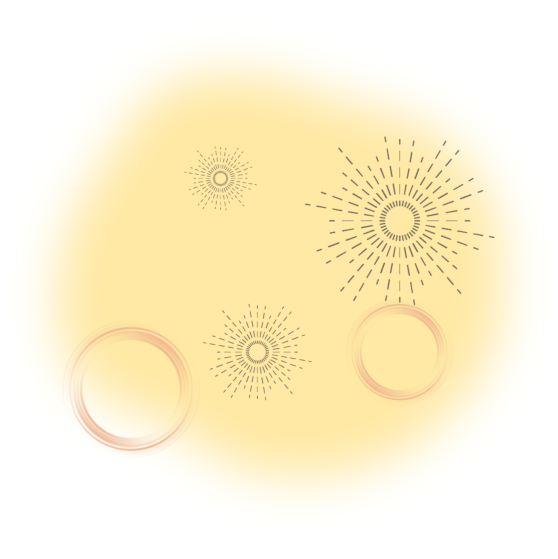

In [98]:
patternPath1 = patternReference1[random.randint(0, len(patternReference1) - 1)]
patternPath2 = patternReference2[random.randint(0, len(patternReference2) - 1)]
pattern1 = cv2.imread(patternPath1, cv2.IMREAD_UNCHANGED)
pattern2 = cv2.imread(patternPath2, cv2.IMREAD_UNCHANGED)

layer1 = generateLayer(1, pattern1, colorMap1)
layer2 = generateLayer(2, pattern2, colorMap2)

layer = addLayer(layer1, layer2)
output = putLayerOnBase(base, layer)

plt.imsave('../../../Resources/Textures/' + flowerName[:-2] + name + flowerName[-2:] + '.png', output)

showImage(output, 7)